<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:200%;
           font-\amily:Arial;letter-spacing:0.5px">

<p width = 20%, style="padding: 10px;
              color:white;">
Regularization
              
</p>
</div>

Data Science Cohort Live NYC June 2023
<p>Phase 3</p>
<br>
<br>

<div align = "right">
<img src="Images/flatiron-school-logo.png" align = "right" width="200"/>
</div>

# Objectives
- Use the algorithm of cross-validation (with `sklearn`)
- Explain the concept of regularization
- Use Lasso and Ridge regularization in model design

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Preventing Overfitting - Regularization
Again, complex models are very flexible in the patterns that they can model but this also means that they can easily find patterns that are simply statistical flukes of one particular dataset rather than patterns reflective of the underlying data-generating process.

When a model has large weights, the model is "too confident". This translates to a model with high variance which puts it in danger of overfitting!

![](images/punishing_model_metaphor.jpeg)

We need to punish large (confident) weights by contributing them to the error function

**Some Types of Regularization:**

1. Reducing the number of features
2. Increasing the amount of data
3. Popular techniques: Ridge, Lasso, Elastic Net

#### Regularization for Linear Regression

Modify our squared error loss function.

$$ L = |\textbf{y} - X \textbf{w}|_2^2 + \lambda |\textbf{w}|^2 $$ 

with $|\textbf{w}|^2 = w_1^2 + w_2^2 + ... + w_m^2$ as sum of squares of the feature weights.

<img src = "Images/ridge_regression_geometric.png" width = 450>

Tug of war between:

Ridge cost: $ \lambda |\textbf{w}|_2^2 = \lambda (w_1^2 + w_2^2)  $
- L2 Regularization (Euclidean distance)

Least squares cost: $ |\textbf{y} - X\textbf{w}|_2^2 $
    

<img src = "Images/ridge_regression_geometric.png" width = 450>

Regularization term Penalizes large weights: 
- **strongly** discourages large fluctuations in $\textbf{w}$ depending on training set.
- i.e. reduces Var[$\textbf{w}$]
- **Can lead to large performance boost on unseen data.**

- the tradeoff: repeating fitting on large number of distinct training sets:
    - Average of $\textbf{w}$ is off from best fit to population

Our goal is to construct a model with:
- as low a bias as possible (gets close to the true $\textbf{w}$ if we had/fit on the entire population)
- as low a *model* variance as possible (spread in $\textbf{w}$ is low):
    - implies $\textbf{w}$ is tightly clustered


Idea of Ridge: 
- Tune $\lambda$ just right. This is something we input as external parameter to model. **Hyperparameter** 
- Cluster of $\textbf{w}$ little off the center of the bullseye
- But: tightly clustered.

With $\lambda$ tuned well:

- not likely to make generalization errors due to large fluctuation in $\textbf{w}$
- But doesnt shift $\textbf{w}$ too far from least squares estimate

OK let's do a Ridge regression.

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

# train test split
from sklearn.model_selection import train_test_split

# preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# model validation: testing model variance with cross validation

from sklearn.model_selection import cross_val_score, cross_validate

In [3]:
birds = sns.load_dataset('penguins')
birds = birds.dropna()

In [4]:
birds.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


Going to use the other features to predict the body mass of a penguin

In [5]:
X = birds.drop('body_mass_g', axis=1)
y = birds['body_mass_g']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X ,y, random_state = 42)

Let's one-hot encode the nominal categoricals

In [7]:
# Taking in other features (category)
ohe = OneHotEncoder(drop='first')
dummies = ohe.fit_transform(X_train[['species', 'island', 'sex']])

# Getting a DF
X_train_onehot = pd.DataFrame(dummies.todense(), columns=ohe.get_feature_names_out(), index=X_train.index)

X_train_onehot.head()

,species_Chinstrap,species_Gentoo,island_Dream,island_Torgersen,sex_Male
321,0.0,1.0,0.0,0.0,1.0
265,0.0,1.0,0.0,0.0,0.0
36,0.0,0.0,1.0,0.0,1.0
308,0.0,1.0,0.0,0.0,0.0
191,1.0,0.0,1.0,0.0,1.0


Attach this to dataframe with numerical variables

In [8]:
X_train_numeric = X_train[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm']]
X_train_df = pd.concat([X_train_numeric, X_train_onehot], axis=1)
X_train_df.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,species_Chinstrap,species_Gentoo,island_Dream,island_Torgersen,sex_Male
321,55.9,17.0,228.0,0.0,1.0,0.0,0.0,1.0
265,43.6,13.9,217.0,0.0,1.0,0.0,0.0,0.0
36,38.8,20.0,190.0,0.0,0.0,1.0,0.0,1.0
308,47.5,14.0,212.0,0.0,1.0,0.0,0.0,0.0
191,53.5,19.9,205.0,1.0,0.0,1.0,0.0,1.0


We have our training feature matrix:
- Apply transformation fit_transformed on train set to test feature matrix.

In [9]:
test_dummies = ohe.transform(X_test[['species', 'island', 'sex']])
test_df = pd.DataFrame(test_dummies.todense(), columns=ohe.get_feature_names_out(),
                       index=X_test.index)
X_test_df = pd.concat([X_test[['bill_length_mm', 'bill_depth_mm',
                              'flipper_length_mm']], test_df], axis=1)
X_test_df.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,species_Chinstrap,species_Gentoo,island_Dream,island_Torgersen,sex_Male
30,39.5,16.7,178.0,0.0,0.0,1.0,0.0,0.0
317,46.9,14.6,222.0,0.0,1.0,0.0,0.0,0.0
79,42.1,19.1,195.0,0.0,0.0,0.0,1.0,1.0
201,49.8,17.3,198.0,1.0,0.0,1.0,0.0,0.0
63,41.1,18.2,192.0,0.0,0.0,0.0,0.0,1.0


In [10]:
lr1 = LinearRegression()
lr1.fit(X_train_df, y_train)

LinearRegression()

In [11]:
lr1.score(X_train_df, y_train)

0.8688983108974326

In [12]:
from sklearn.metrics import mean_squared_error
y_pred = lr1.predict(X_test_df)
np.sqrt(mean_squared_error(y_pred, y_test))

253.98121177477861

Wow that's a good $R^2$ value!

- Estimate how we are doing on unseen data with cross validation.

In [13]:
cv_results = cross_validate(X=X_train_df, y=y_train, estimator=lr1, cv=10, scoring=('r2', 'neg_mean_squared_error'),
                return_train_score=True)

How well model explains training fold data in each iteration cross validation:

In [14]:
train_res = cv_results['train_r2']
train_res

array([0.86804859, 0.87184762, 0.86639447, 0.86902092, 0.86919768,
       0.86625747, 0.86680671, 0.8768277 , 0.869645  , 0.86906114])

It's fitting well each time in the 10 iterations.

How does the validation look?

In [15]:
test_res = cv_results['test_r2']
test_res

array([0.86092305, 0.68845759, 0.88730555, 0.85315477, 0.85555065,
       0.88779582, 0.87796788, 0.71839192, 0.85080305, 0.86263277])

In [16]:
test_res.mean()

0.8342983053829107

In [17]:
test_res.std(ddof = 1)

0.0706115684406588

Good average test performance and relatively low variance.

In [18]:
RMSE_train = np.sqrt(np.abs(cv_results['train_neg_mean_squared_error']))
RMSE_train

array([294.39902869, 295.54794956, 295.83205215, 287.46270287,
       298.1599986 , 295.74918118, 293.40476336, 291.7275227 ,
       290.82138953, 292.37523149])

In [19]:
RMSE_train.mean()

293.54798201361626

In [20]:
RMSE_train.std(ddof = 1)

3.0773718597543525

In [21]:
RMSE_test = np.sqrt(np.abs(cv_results['test_neg_mean_squared_error']))
RMSE_test

array([297.90893127, 291.59992285, 281.7832529 , 358.30773939,
       260.32367156, 281.50266999, 309.16756673, 319.73503557,
       331.38649842, 316.03365957])

Clearly larger average RMSE and variance of RMSE in the test set. But still pretty decent.

In [22]:
RMSE_test.mean()

304.77489482634087

In [23]:
RMSE_test.std(ddof = 1)

28.305179526794113

But...I'm a greedy man.

I want to do better than this. 
- I'm going to add some polynomials to get a more complex model.

My motivation:
    
- More complex model = better able to capture more complex relationships between mass and other variables.
- Better prediction.

#### Adding model complexity

In [24]:
from sklearn.preprocessing import PolynomialFeatures

In [25]:
pf = PolynomialFeatures(degree=3)
X_poly_train = pd.DataFrame(pf.fit_transform(X_train_df))



In [26]:
X_poly_test = pf.transform(X_test_df)

In [27]:
X_train_df.shape

(249, 8)

In [28]:
X_poly_train.shape

(249, 165)

In [29]:
poly_lr = LinearRegression()
poly_lr.fit(X_poly_train, y_train)

LinearRegression()

In [30]:
poly_lr.score(X_poly_train, y_train)

0.8929837785732454

In [31]:
lr1.score(X_train_df, y_train)

0.8688983108974326

About a 3% improvement: 
- that could mean money in other contexts.

In [32]:
poly_cv_results = cross_validate(
                X=X_poly_train, 
                y=y_train,
                estimator=poly_lr, 
                cv=10,
                scoring=('r2', 'neg_mean_squared_error'),
                return_train_score=True
)

In [33]:
poly_train_res = poly_cv_results['train_r2']
poly_train_res

array([0.81274492, 0.90586698, 0.8712184 , 0.86791377, 0.80439497,
       0.89249437, 0.8923507 , 0.88343241, 0.91414692, 0.80533058])

In [34]:
poly_train_res.mean()

0.8649894008090362

In [35]:
poly_train_res.std(ddof =1)

0.042085158505908674

Wow...I'm ready to brag to my boss.

- But let's check the performance on the validation folds.

In [36]:
poly_valid_res = poly_cv_results['test_r2']
poly_valid_res

array([ 0.58415864, -0.98182008,  0.5788367 ,  0.67200787, -0.16406106,
        0.51348532,  0.13544697,  0.12022603,  0.81904846,  0.56611475])

In [37]:
poly_valid_res.mean()

0.28434436041959793

In [38]:
poly_valid_res.std(ddof = 1)

0.5372823595699721

In [39]:
RMSE_polytest = np.sqrt(np.abs(poly_cv_results['test_neg_mean_squared_error']))
RMSE_polytest

array([515.13348704, 735.46317405, 544.73989696, 535.49815052,
       738.99881498, 586.1732205 , 822.91063263, 565.13632479,
       364.95219858, 561.66739411])

In [40]:
RMSE_polytest.mean()

597.0673294157234

In [41]:
RMSE_polytest.std(ddof=1)

133.25584938972747

<center><img src = "Images/punch_chuck_norris.gif" width = 400/></center>
<center>You just got punched in the face by the bias-variance problem.</center>

Fit an overly complex model:
- Doesn't generalize well.

Let's try regularizing polynomial model:
$$ L = |\textbf{y} - X \textbf{w}|_2^2 + \lambda |\textbf{w}|_2^2 $$


- reduce the floppiness/complexity of model
- but still keep *some* of the complexity added by these polynomial features.

- Reduce Var[$\textbf{w}$].
- Get model predictions more representative of population.

In [42]:
ss = StandardScaler()
pf = PolynomialFeatures(degree=3)

# You should always be sure to _standardize_ your data before
# applying regularization!

X_train_processed = pf.fit_transform(ss.fit_transform(X_train_df))
X_test_processed = pf.transform(ss.transform(X_test_df))

Absolutely need to standardize/normalize features:

 $$ L = |\textbf{y} - X \textbf{w}|_2^2 + \lambda |\textbf{w}|_2^2 $$

L2 regularization cost function makes no sense otherwise. 
- Weights will be on different scales if features not normalized.

In [43]:
# 'Lambda' is the standard variable for the strength of the
# regularization (as in the above formulas), but since lambda
# is a key word in Python, these sklearn regularization tools
# use 'alpha' instead.
rr = Ridge(alpha=100, random_state=42)

rr.fit(X_train_processed, y_train)

Ridge(alpha=100, random_state=42)

In [44]:
rr.score(X_train_processed, y_train)

0.8858195769398121

In [45]:
lr1.score(X_train_df, y_train)

0.8688983108974326

Let' s cross validate this.

In [46]:
rr_cv_results = cross_validate(
                X=X_train_processed, 
                y=y_train,
                estimator=rr, 
                cv=10,
                scoring=('r2', 'neg_mean_squared_error'),
                return_train_score=True
)

Get $R^2$ on train folds of cross validation trials:

In [47]:
rr_cv_results['train_r2']

array([0.88768944, 0.886945  , 0.88701008, 0.88207217, 0.88887472,
       0.8843449 , 0.88600675, 0.88848898, 0.88421626, 0.88539415])

Get $R^2$ on validation folds of cross validation trials:

In [48]:
rr_cv_results['test_r2']

array([0.83317242, 0.75269689, 0.86749677, 0.86884944, 0.8153149 ,
       0.88686033, 0.85418436, 0.79593331, 0.86108265, 0.86365454])

In [49]:
rr_cv_results['test_r2'].mean()

0.8399245628148447

In [50]:
rr_cv_results['test_r2'].std(ddof = 1)

0.041108370451921575

In [51]:
RMSE_rrtest = np.sqrt(np.abs(rr_cv_results['test_neg_mean_squared_error']))
RMSE_rrtest

array([326.27955651, 259.80266776, 305.54638793, 338.61900856,
       294.35524921, 282.67372802, 337.95502919, 272.1784423 ,
       319.76658789, 314.85610328])

In [52]:
RMSE_rrtest.mean()

305.20327606509454

In [53]:
RMSE_rrtest.std(ddof = 1)

27.3170643856261

L2 regularized polynomial model:
- A little bit worse than my basic linear model.
- Much much better than the un-regularized polynomial model.

Could I do better? Possibly.

- Tune hyperparameter $\lambda$.

#### Tuning hyperparameters

- Don't know what $\lambda$ will allow model to perform best on validation sets.
- Need to tune this.

- Adjust model stiffness/regularization parameter
- Assess model performance in validation testing.

### Optimizing the Regularization Hyperparameter

#### The most basic hyperparameter tuning method: Make a loop!

The regularization strength could sensibly be any nonnegative number, so there's no way to check "all possible" values. It's often useful to try several values that are different orders of magnitude.

In [54]:
alphas = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1e3, 1e4]
cv_scores = []

for alpha in alphas:
    rr = Ridge(alpha=alpha, random_state=42)
    cv_loop_results = cross_validate(
                X=X_train_processed, 
                y=y_train,
                estimator=rr, 
                cv=10,
                scoring=('neg_mean_squared_error'))
    cv_scores.append(np.mean(np.sqrt(np.abs(cv_loop_results['test_score']))))

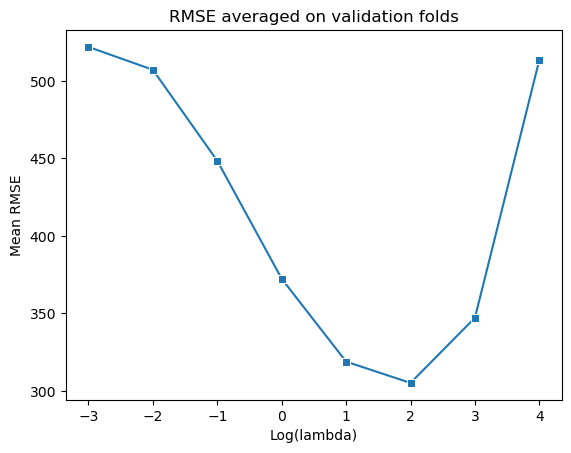

In [55]:
fig, ax = plt.subplots()
sns.lineplot(x = np.log10(alphas), y = cv_scores, marker = 's', ax = ax)
ax.set_xlabel('Log(lambda)')
ax.set_ylabel('Mean RMSE')
ax.set_title('RMSE averaged on validation folds')
plt.show()

Could fine tune:
- But of hyperparameter values tried $\lambda = 100$ is best.

Now we *finally* report results on the true test set:
- We have not fit optimized on it.
- Have not tuned hyperparameters to see how well it performs on validation folds.

**Test/hold-out set is our true final gold standard**

In [56]:
rr = Ridge(alpha = 100, random_state = 42)
rr.fit(X_train_processed, y_train)

Ridge(alpha=100, random_state=42)

In [57]:
y_pred = rr.predict(X_test_processed)

In [58]:
ridge_RMSE_holdout = np.sqrt(mean_squared_error(y_pred, y_test))
ridge_RMSE_holdout

265.44225908366604

Given the scale of the penguin body mass (g): this is good.

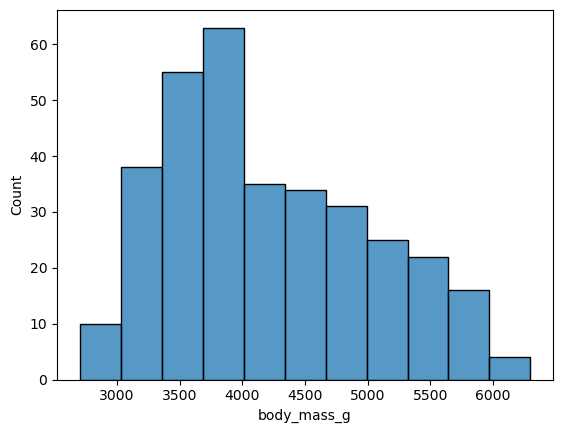

In [59]:
sns.histplot(y);

#### Takeaways of what we just did

- Polynomial model: poor prediction performance.
- L2 regularized the polynomial regression model (Ridge regression) + tuning
- **Much** better test performance than unregularized polynomial model.

But:   
- Our simple linear model with no polynomial worked well.
- Almost as well as polynomial features
- Think carefully before adding model complexity.

A simple model with less number of good quality predictive features may work as well if not better.

Logical extension:
- Features that are correlated but don't want to throw them away.
- L2 regularized linear model + tuning:
    - don't throw out features.
    - get better test performance than OLS by reducing weight variance.


Sometimes though: throwing away features might work better:
- Learn good features only with high predictive power
- Chuck the rest.

#### L1 Regularization (LASSO)

$$ L = |\textbf{y} - X \textbf{w}|_2^2 + \lambda |\textbf{w}|_1 $$

with $|\textbf{w}|_1 = |w_1| + |w_2| + ... + |w_m|$ as sum of absolute magnitude of the feature weights.

Taxi cab vs Euclidean distance:

<img src = "Images/metrics.png" width = 450/>

Circle in terms of L2 vs L1 distance:

"Circle" in L1:
<img src = "Images/taxcabgeometry.jpg" width = 400/>

"Circles" for different metrics

<img src = "Images/circles.png" width = 400/>

Why use the L1 magnitude $|\textbf{w}|_1$ for regularization?

LASSO encourages model weight sparsity: 
- prefers to drive weights $w_i$ for features with little predictive power to 0.

<img src = "Images/different_metric_regularization.png" width = 600 />

Perform LASSO regression with scikit-learn:

In [60]:
from sklearn.linear_model import Lasso

Find the best LASSO model: tune regularization hyperparameter.

In [61]:
alphas = [1, 10, 100, 1e3, 1e4]
cv_lasso_scores = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha, random_state=42, max_iter = 10000)
    cv_loop_results = cross_validate(
                X=X_train_processed, 
                y=y_train,
                estimator=lasso, 
                cv=10,
                scoring=('neg_mean_squared_error'))
    cv_lasso_scores.append(np.mean(np.sqrt(np.abs(cv_loop_results['test_score']))))

In [62]:
alphas

[1, 10, 100, 1000.0, 10000.0]

In [63]:
cv_lasso_scores

[344.8768456443569,
 301.76131575156853,
 340.26932591239273,
 699.4512087784858,
 811.3632576452586]

The best LASSO model:

In [64]:
lasso_opt = Lasso(alpha=10, random_state=42,  max_iter = 100000)
lasso_opt.fit(X_train_processed, y_train)

y_pred = lasso_opt.predict(X_test_processed) # get final test prediction

In [65]:
lasso_RMSE = np.sqrt(mean_squared_error(y_pred, y_test))
lasso_RMSE

267.376455546584

In [66]:
ridge_RMSE_holdout

265.44225908366604

Comparable between ridge and LASSO. LASSO tends to have higher weight variance than ridge.

But what's the real difference?

In [67]:
print(rr.coef_)

[  0.          29.32960231   0.8046896   38.17109867  -4.10436699
  40.27228066 -10.86847643  -1.58292157  37.48222572 -14.02382992
  -4.57236431  -5.95361058 -20.50428693  -0.75058332 -24.04661014
 -10.05361186 -10.79395713 -10.65313696  -1.72724584   5.1723557
 -14.20925988   5.06212976  -0.25055749 -17.27288405   0.57708637
 -16.2812928    7.40733877 -20.38843876 -19.91851821   4.7657019
  -5.75859125 -17.85396187   0.47018371   2.37087442 -22.65473387
  23.22926662 -23.72344945 -13.9956209   -3.80574878  -5.11166274
   5.35232607  -8.82144444  -3.60074121  -9.27420928  -2.71133015
  -4.99539005   4.03028956   9.62441097   1.62602145  17.78209921
  10.12563598  12.69525486  16.44364281  14.71106968  13.32988964
   4.32024456  -9.68390238   5.32047154  -0.74803361   1.05694406
  -7.35649966  23.17919449  10.28762348  20.77489205   9.9559688
  13.05856002   0.56126663   4.34217579   5.87326338   7.20871856
   6.7571956   28.89666184   1.20704504  -0.47418842  25.29255039
  18.01999863

In [68]:
lasso_opt.coef_

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -2.69391521e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -5.10132627e+01,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.47906338e+01,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

## The Strategy Behind Ridge / Lasso / Elastic Net

Overfit models overestimate the relevance that predictors have for a target. Thus overfit models tend to have **overly large coefficients**. 

Generally, overfitting models come from a result of high model variance. High model variance can be caused by:

- having irrelevant or too many predictors
- multicollinearity
- large coefficients

#### Ridge 
When we introduce many features that:
- we believe may all have some predictive power.
- want to heavily penalize weight variance

#### LASSO

We have dataset with many highly correlated features:
- believe many are not actually adding to predictive power.
- willing to cut away marginally unimportant features.


Which is better:
- depends on dataset
- modeling goal 

### LEVEL UP - Elastic Net!
Naturally, the Elastic Net has the same interface through sklearn as the other regularization tools! The only difference is that we now have to specify how much of each regularization term we want. The name of the parameter for this (represented by $\rho$ above) in sklearn is `l1_ratio`.

In [69]:
from sklearn.linear_model import ElasticNet

enet = ElasticNet(alpha=10, l1_ratio=0.1, random_state=42)
enet.fit(X_train_processed, y_train)

ElasticNet(alpha=10, l1_ratio=0.1, random_state=42)

In [70]:
enet.score(X_train_processed, y_train)

0.7967984860498589

In [71]:
enet.score(X_test_processed, y_test)

0.8341204160263829

Setting the `l1_ratio` to 1 is equivalent to the lasso:

In [72]:
ratios = np.linspace(0.01, 1, 100)
preds = []

for ratio in ratios:
    enet = ElasticNet(alpha=100, l1_ratio=ratio, random_state=42)
    enet.fit(X_train_processed, y_train)
    preds.append(enet.predict(X_test_processed[0].reshape(1, -1)))

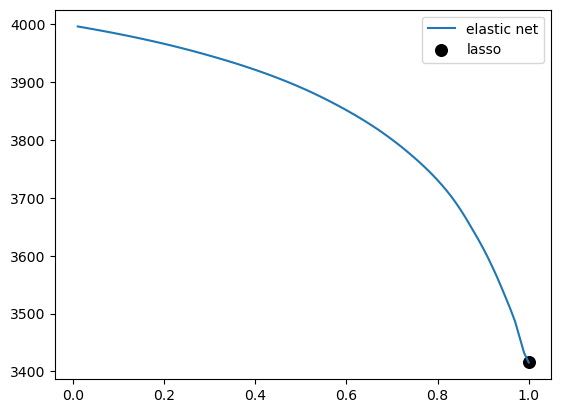

In [73]:
fig, ax = plt.subplots()

lasso = Lasso(alpha=100, random_state=42)
lasso.fit(X_train_processed, y_train)
lasso_pred = lasso.predict(X_test_processed[0].reshape(1, -1))

ax.plot(ratios, preds, label='elastic net')
ax.scatter(1, lasso_pred, c='k', s=70, label='lasso')
plt.legend();

#### Note on `ElasticNet()`
Is an Elastic Net with `l1_ratio` set to 0 equivalent to the ridge? In theory yes. But in practice no. It looks like the `ElasticNet()` predictions on the first test data point as `l1_ratio` shrinks are tending toward some value around 3400. Let's check to see what prediction `Ridge()` gives us:

In [74]:
ridge = Ridge(alpha=10, random_state=42)
ridge.fit(X_train_processed, y_train)
ridge.predict(X_test_processed[0].reshape(1, -1))[0]

3092.7421075221764

If you check the docstring for the `ElasticNet()` class you will see:
- that the function being minimized is slightly different from what we saw above; and
- that the results are unreliable when `l1_ratio` $\leq 0.01$.

**Exercise**: Visualize the difference in this case between `ElasticNet(l1_ratio=0.01)` and `Ridge()` by making a scatterplot of each model's predicted values for the first ten points in `X_test_processed`. Use `alpha=10` for each model.

        Level Up: Make a second scatterplot that compares the predictions on the same data
        points between ElasticNet(l1_ratio=1) and Lasso().

<details>
    <summary> Answer
    </summary>
    
```python
fig, ax = plt.subplots()
enet_r = ElasticNet(alpha=10, l1_ratio=0.01, random_state=42)
enet_r.fit(X_train_processed, y_train)
preds_enr = enet_r.predict(X_test_processed[:10])
preds_ridge = ridge.predict(X_test_processed[:10])
ax.scatter(np.arange(10), preds_enr)
ax.scatter(np.arange(10), preds_ridge);
```
</details>

<details>
    <summary>
        Level Up Answer
    </summary>

```python
fig, ax = plt.subplots()
enet_l = ElasticNet(alpha=10, l1_ratio=1, random_state=42)
enet_l.fit(X_train_processed, y_train)
preds_enl = enet_l.predict(X_test_processed[:10])
preds_lasso = lasso.predict(X_test_processed[:10])
ax.scatter(np.arange(10), preds_enl)
ax.scatter(np.arange(10), preds_lasso);
```
</details>

#### Fitting Regularized Models with Cross-Validation
Our friend `sklearn` also includes tools that fit regularized regressions *with cross-validation*: `LassoCV`, `RidgeCV`, and `ElasticNetCV`.


**Exercise**: Use `RidgeCV` to fit a seven-fold cross-validated ridge regression model to our `X_train_processed` data and then calculate $R^2$ and the RMSE (root-mean-squared error) on our test set.


<details>
    <summary>
        Answer
    </summary>
    
```python
rcv = RidgeCV(cv=7)
rcv.fit(X_train_processed, y_train)
rcv.score(X_test_processed, y_test)
np.sqrt(mean_squared_error(y_test, rcv.predict(X_test_processed))
```
</details>

## Level Up Exercise: Name that Model!

Consider the following scenarios and describe them according to bias and variance. There are four possibilities:

- a. The model has low bias and high variance.
- b. The model has high bias and low variance.
- c. The model has both low bias and low variance.
- d. The model has both high bias and high variance.

**Scenario 1**: The model has a low RMSE on training and a low RMSE on test.
<details>
    <summary> Answer
    </summary>
    c. The model has both low bias and low variance.
    </details>

**Scenario 2**: The model has a high $R^2$ on the training set, but a low $R^2$ on the test.
<details>
    <summary> Answer
    </summary>
    a. The model has low bias and high variance.
    </details>

**Scenario 3**: The model performs well on data it is fit on and well on data it has not seen.
<details>
    <summary> Answer
    </summary>
    c. The model has both low bias and low variance.
    </details>
  

**Scenario 4**: The model has a low $R^2$ on training but high on the test set.
<details>
    <summary> Answer
    </summary>
    d. The model has both high bias and high variance.
    </details>

**Scenario 5**: The model leaves out many of the meaningful predictors, but is consistent across samples.
<details>
    <summary> Answer
    </summary>
    b. The model has high bias and low variance.
    </details>

**Scenario 6**: The model is highly sensitive to random noise in the training set.
<details>
    <summary> Answer
    </summary>
    a. The model has low bias and high variance.
    </details>